# COGS 108 - Final Project (Homelessness & Housing Prices in CA)

# Overview

In this report we set to study if there is any correlation between the housing price and the number of homeless individuals in counties accross California. The motivation for this study came from the recent homelessness crisis in California, and the interesting phenomenon that certain neighborhoods or counties seem to have more homeless people than others. One measureable difference between these counties are their average housing price which we thought perhaps may be correlated with the number of homeless people. We hypothesized that increase in housing cost in a neighborhood would decrease number of people in that neighborhood. So to study the presence or absence of such a correlation we used the Zillow "Home Value Index (ZHVI)" dataset and Kaggle "Homelessness in the United States, 2007 to 2016" dataset to find any trends in the years 2007 to 2016 among 28 different counties in California. Our analysis found no significant correlation between average housing price and number of homeless people across California. 

# Names

- Allen Chung
- Amita Haravu
- Arman Mansourian
- Antoinette Nguyen
- Areg Stepanyan

<a id='research_question'></a>
# Research Question

Is an increase of a city's housing prices **in California** correlated to rates of homelessness in that city? We can consider different types of homelessness in our analysis. Some potential candidates include:
- sheltered vs. unsheltered homeless population
- chronic vs. non-chronic homeless population
- individual vs. family homeless population

or any combination of the above.

<a id='background'></a>

## Background & Prior Work

Prior work by Zillow research explored rates of homelessness in relation to housing cost as a fraction of income [1]. Their study addressed the 30% anectode for the threshold of income, "It has long been a real estate rule of thumb that a person’s housing costs should not exceed roughly 30 percent of their income, and this research finds empirical evidence to support that adage at the community level."

Additionally, an article at KPBS News looked at similar metrics within the state of California, reiterating the difficulty low-income households have in securing affordable housing [2]. They note the disadvantage Californians have due to the more expensive housing market in the state: "the median monthly housing costs of homeowners with mortgages in California is 47% higher than the national average." They also include statistics that supercede the 30% threshold mentioned in the Zillow study, "More than 25% of renters are severely cost burdened, paying 50 percent or more of their income in rent."

These are only a couple of studies, articles, and anecdotal evidence linking the two together which provides us with hope that we can draw a conclusive result from our data analysis and hypothesis testing.

References:
- [1] "Homelessness Rises Faster Where Rent Exceeds a Third of Income"  
  https://www.zillow.com/research/homelessness-rent-affordability-22247/#_edn1
- [2] "A Deeper Dive Into California’s Housing And Homelessness Crisis"  
  https://www.kpbs.org/news/2018/aug/28/deeper-dive-californias-housing-and-homelessness-c/

# Hypothesis


We hypothesize that increases in housing cost in both raw value and also in proportion to income are positively correlated with homelessness rates both in general and potentially with regards to specific subsets of the homeless population mentioned above in the Research Question section. This hypothesis seems to be supported by a handful of studies mentioned above and a general cultural concensus that this seems to be the case. However we will aim to explore this within our study using data on homelessness and housing.

# Dataset(s)

Homelessness dataset:
- Dataset Name: Homelessness in the United States, 2007 to 2016 (Kaggle)
- [Link to the dataset](https://www.kaggle.com/adamschroeder/homelessness)
- Number of observations: 86529

Homelessness dataset contains various measures on different homelessness types as can be seen in `sandbox.ipynb` EDA mockup. We have data by CoC areas and by state between the years 2007 and 2016.

Housing market dataset:
- Dataset Name: Zillow Home Value Index (ZHVI) Dataset
- [Link to the dataset](https://www.zillow.com/research/data/)
- Number of observations: ~858000 (2860 regions * 25 years * 12 months)

Housing market dataset contains housing price data per state, per county at one month intervals between the years of 1996 and 2021. We will crop only those years overlapping with our homelessness dataset and aggregate data across months into a yearly average.

Total population of California dataset:
- Dataset Name: Population Estimates for Counties and Cities – 1970 to 2018
- [Link to the dataset](https://www.counties.org/data-and-research)
- Number of observations: ~26,453 (569 regions * 48 years)


We will combine the three datasets by matching the years which all datasets contain, additionally we have to clean up the county labels on the homelessness dataset as some counties are grouped together. We would have to do similar grouping in the housing data and total population data and match the labels before merging them into one `pd.DataFrame`.

# Setup

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import patsy
import statsmodels.api as sm

# Data Cleaning

## Housing Data: Cleaning

In [5]:
# First let us clean the Zillow housing data
zillow = pd.read_csv('data/zillow.csv')

In [6]:
zillow.head()

,RegionID,SizeRank,RegionName,RegionType,StateName,State,Metro,StateCodeFIPS,MunicipalCodeFIPS,1996-01-31,...,2020-06-30,2020-07-31,2020-08-31,2020-09-30,2020-10-31,2020-11-30,2020-12-31,2021-01-31,2021-02-28,2021-03-31
0,3101,0,Los Angeles County,County,CA,CA,Los Angeles-Long Beach-Anaheim,6,37,180478.0,...,678605.0,683821.0,691363.0,699700.0,706384.0,712663.0,718192.0,723319.0,728851.0,734143.0
1,139,1,Cook County,County,IL,IL,Chicago-Naperville-Elgin,17,31,155647.0,...,257737.0,259101.0,260822.0,263250.0,265834.0,268071.0,270074.0,271567.0,274045.0,276354.0
2,1090,2,Harris County,County,TX,TX,Houston-The Woodlands-Sugar Land,48,201,101093.0,...,206072.0,207008.0,208090.0,209840.0,211443.0,213386.0,215203.0,217318.0,219461.0,220875.0
3,2402,3,Maricopa County,County,AZ,AZ,Phoenix-Mesa-Scottsdale,4,13,116695.0,...,309870.0,312856.0,316868.0,321718.0,327044.0,332815.0,338893.0,345971.0,353011.0,361046.0
4,2841,4,San Diego County,County,CA,CA,San Diego-Carlsbad,6,73,183154.0,...,635314.0,639366.0,645671.0,654918.0,665196.0,675307.0,685312.0,695461.0,705362.0,715058.0


In [7]:
# We see many features that are not relevant for our hypothesis, let's drop them
zillow = zillow.drop([
    'RegionID', 'SizeRank', 'RegionType', 'StateName', 'Metro', 'StateCodeFIPS', 'MunicipalCodeFIPS'
], axis=1)

In [8]:
zillow.head()

,RegionName,State,1996-01-31,1996-02-29,1996-03-31,1996-04-30,1996-05-31,1996-06-30,1996-07-31,1996-08-31,...,2020-06-30,2020-07-31,2020-08-31,2020-09-30,2020-10-31,2020-11-30,2020-12-31,2021-01-31,2021-02-28,2021-03-31
0,Los Angeles County,CA,180478.0,180516.0,180586.0,180738.0,180878.0,181061.0,181294.0,181281.0,...,678605.0,683821.0,691363.0,699700.0,706384.0,712663.0,718192.0,723319.0,728851.0,734143.0
1,Cook County,IL,155647.0,155418.0,155061.0,154934.0,154495.0,154556.0,154327.0,154646.0,...,257737.0,259101.0,260822.0,263250.0,265834.0,268071.0,270074.0,271567.0,274045.0,276354.0
2,Harris County,TX,101093.0,101177.0,101188.0,101342.0,101490.0,101588.0,101625.0,101690.0,...,206072.0,207008.0,208090.0,209840.0,211443.0,213386.0,215203.0,217318.0,219461.0,220875.0
3,Maricopa County,AZ,116695.0,117025.0,117397.0,118115.0,118812.0,119441.0,120026.0,120562.0,...,309870.0,312856.0,316868.0,321718.0,327044.0,332815.0,338893.0,345971.0,353011.0,361046.0
4,San Diego County,CA,183154.0,182798.0,182602.0,182193.0,182004.0,181848.0,181679.0,181416.0,...,635314.0,639366.0,645671.0,654918.0,665196.0,675307.0,685312.0,695461.0,705362.0,715058.0


In [9]:
# We have features for each month of the year, we want aggregated year data
# First we transpose data matrix, drop the first two categorical features, leaving only dates
zillow_dt = zillow.T[2:]

In [10]:
# We see some NaN values, we'll come back to those soon
zillow_dt.head()

,0,1,2,3,4,5,6,7,8,9,...,2850,2851,2852,2853,2854,2855,2856,2857,2858,2859
1996-01-31,180478,155647,101093,116695,183154,213188,162993,116191,96931,165981,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1996-02-29,180516,155418,101177,117025,182798,214027,162564,116302,96978,165604,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1996-03-31,180586,155061,101188,117397,182602,213897,162206,116449,97180,165499,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1996-04-30,180738,154934,101342,118115,182193,213874,161663,116720,97512,165182,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1996-05-31,180878,154495,101490,118812,182004,213398,161397,116982,97869,165126,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
# First we cast the new date indices to datetime format
zillow_dt.index = pd.to_datetime(zillow_dt.index)

In [12]:
# Now that we have indices in datetime we can group by their year and take mean values of price
zillow_dt = zillow_dt.apply(pd.to_numeric).groupby(zillow_dt.index.year).mean()

In [13]:
zillow_dt.head()

,0,1,2,3,4,5,6,7,8,9,...,2850,2851,2852,2853,2854,2855,2856,2857,2858,2859
1996,180843.666667,155333.916667,101678.416667,119629.166667,181849.666667,213324.250000,161863.583333,117624.083333,98118.916667,165225.083333,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1997,180388.416667,157521.583333,102520.916667,125739.666667,183539.583333,218710.083333,167226.583333,120887.500000,100549.750000,169367.166667,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1998,192988.833333,154522.500000,105523.083333,132100.166667,202102.083333,240059.250000,176190.666667,124562.583333,103800.833333,178097.916667,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1999,210151.333333,169936.000000,110017.583333,140215.666667,224234.416667,265997.000000,190686.750000,129105.416667,109571.083333,192840.500000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000,229644.500000,184289.916667,114191.666667,149800.750000,256543.750000,296795.833333,213640.000000,135751.416667,115484.583333,216761.000000,...,49215.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [14]:
# Take only years overlapping with homeless data (2007-2016)
zillow_dt = zillow_dt.iloc[11:21]

In [15]:
zillow_dt.head()

,0,1,2,3,4,5,6,7,8,9,...,2850,2851,2852,2853,2854,2855,2856,2857,2858,2859
2007,586322.666667,306505.583333,142450.083333,274582.000000,530797.083333,699848.000000,449509.166667,358401.00,142604.833333,405073.833333,...,61396.416667,NaN,NaN,NaN,391793.166667,NaN,NaN,NaN,NaN,258967.833333
2008,490321.750000,284259.583333,140559.750000,223237.250000,448195.416667,578655.166667,443194.333333,293066.25,137687.166667,390381.666667,...,60777.500000,NaN,NaN,123230.000000,330411.750000,137056.916667,NaN,NaN,NaN,253498.083333
2009,409902.000000,243919.500000,136903.666667,175776.416667,382918.083333,515971.333333,407200.833333,210489.50,132473.083333,349139.166667,...,58612.416667,NaN,54213.00,124548.833333,305317.916667,131251.833333,NaN,NaN,NaN,244987.666667
2010,408818.250000,223885.750000,135852.833333,158723.833333,389373.750000,522224.000000,402180.000000,183502.25,130703.416667,338213.500000,...,53048.166667,NaN,52185.00,124306.916667,309896.333333,116728.916667,117119.500000,NaN,NaN,233841.250000
2011,385554.000000,200146.083333,129300.750000,140470.500000,366685.000000,491025.000000,404770.000000,170275.25,123815.583333,338625.666667,...,49185.416667,NaN,50964.25,120978.416667,298799.833333,103366.583333,113941.666667,NaN,NaN,224774.166667


In [16]:
# Now we bring back in the dropped categorical values and re-transpose
zillow = pd.concat([zillow.T[:2], zillow_dt]).T

In [17]:
zillow.head()

,RegionName,State,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
0,Los Angeles County,CA,586323,490322,409902,408818,385554,380038,445363,490570,517887,555353
1,Cook County,IL,306506,284260,243920,223886,200146,184387,195705,212413,220276,230201
2,Harris County,TX,142450,140560,136904,135853,129301,128806,139408,154562,168476,176429
3,Maricopa County,AZ,274582,223237,175776,158724,140470,156752,190637,207225,219501,235134
4,San Diego County,CA,530797,448195,382918,389374,366685,366263,428638,468207,487545,521093


In [18]:
# Our hypothesis focuses on California, lets filter all CA regions
zillow = zillow[zillow['State'] == 'CA'].reset_index(drop=True)

In [19]:
# Make sure we have all 58 counties in CA
zillow.shape

(58, 12)

In [20]:
# Below is data for all 58 counties of CA, we notice some NaN values
zillow

,RegionName,State,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
0,Los Angeles County,CA,586323,490322,409902,408818,385554,380038,445363,490570,517887,555353
1,San Diego County,CA,530797,448195,382918,389374,366685,366263,428638,468207,487545,521093
2,Orange County,CA,699848,578655,515971,522224,491025,487953,575525,617887,642456,676841
3,Riverside County,CA,428201,319928,237906,233050,225400,227039,268788,305531,318106,336390
4,San Bernardino County,CA,384338,290267,205512,197827,190431,189417,226379,271005,285717,306059
5,Santa Clara County,CA,728433,644945,620980,639851,603327,643052,773227,857893,925831,973299
6,Alameda County,CA,594502,521262,467026,473371,435608,431340,544061,625558,690713,761856
7,Sacramento County,CA,346768,279016,227401,213851,194087,190498,242873,277960,291806,319122
8,Contra Costa County,CA,543255,448571,372242,370886,338834,350533,420544,515333,572488,603151
9,Fresno County,CA,300646,240052,184072,174776,153780,154231,176993,198433,206572,219263


In [21]:
# Let's see specifically where the NaN values are
zillow[zillow.isna().any(axis=1)]

,RegionName,State,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
15,Stanislaus County,CA,NaN,202963,162168,154783,145187,145171,182700,225748,241048,264940
40,Tehama County,CA,NaN,204066,173890,167892,161372,163379,184464,202454,207099,214062
41,Tuolumne County,CA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
51,Inyo County,CA,NaN,NaN,NaN,NaN,NaN,246478,280695,317124,331472,346071


Tuolumne and Inyo Counties are missing far too many values but Stanislaus and Tehema are only missing 2007... We can either drop all four or only drop the first two and remove 2007 from homeless dataset. We decided it would be better to just drop these cities as the data from 2007 being dropped would be much more data lost in homeless dataset.

In [22]:
# Drop four counties above by index and reset indices
zillow = zillow.drop([15, 40, 41, 51]).reset_index(drop=True)

In [23]:
# Make sure no NaN values remain
zillow.isna().values.any()

False

In [24]:
zillow.head()

,RegionName,State,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
0,Los Angeles County,CA,586323,490322,409902,408818,385554,380038,445363,490570,517887,555353
1,San Diego County,CA,530797,448195,382918,389374,366685,366263,428638,468207,487545,521093
2,Orange County,CA,699848,578655,515971,522224,491025,487953,575525,617887,642456,676841
3,Riverside County,CA,428201,319928,237906,233050,225400,227039,268788,305531,318106,336390
4,San Bernardino County,CA,384338,290267,205512,197827,190431,189417,226379,271005,285717,306059


In the homelessness dataset the years are contained within an independent feature, we want to accomplish this structure in this dataset as well so we can use `pd.melt` to do so.

In [25]:
zillow = pd.melt(zillow, id_vars=['RegionName', 'State'], var_name='Year', value_name='Price')

In [26]:
zillow.head()

,RegionName,State,Year,Price
0,Los Angeles County,CA,2007,586323
1,San Diego County,CA,2007,530797
2,Orange County,CA,2007,699848
3,Riverside County,CA,2007,428201
4,San Bernardino County,CA,2007,384338


In [27]:
# Double check LA County data from above to make sure this did what we wanted. Looks good!
zillow[zillow['RegionName'] == 'Los Angeles County']

,RegionName,State,Year,Price
0,Los Angeles County,CA,2007,586323
54,Los Angeles County,CA,2008,490322
108,Los Angeles County,CA,2009,409902
162,Los Angeles County,CA,2010,408818
216,Los Angeles County,CA,2011,385554
270,Los Angeles County,CA,2012,380038
324,Los Angeles County,CA,2013,445363
378,Los Angeles County,CA,2014,490570
432,Los Angeles County,CA,2015,517887
486,Los Angeles County,CA,2016,555353


In [28]:
# Finally let's check the data types of our features
zillow.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 540 entries, 0 to 539
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   RegionName  540 non-null    object
 1   State       540 non-null    object
 2   Year        540 non-null    object
 3   Price       540 non-null    object
dtypes: object(4)
memory usage: 17.0+ KB


In [29]:
# We want to cast the Year and Price as integers, not objects
zillow['Year'] = zillow['Year'].astype(int)
zillow['Price'] = zillow['Price'].astype(int)

In [30]:
# Check to make sure we did what we wanted. Looks good!
zillow.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 540 entries, 0 to 539
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   RegionName  540 non-null    object
 1   State       540 non-null    object
 2   Year        540 non-null    int32 
 3   Price       540 non-null    int32 
dtypes: int32(2), object(2)
memory usage: 12.8+ KB


In [31]:
# Finally let's rename the columns to be more pythonic and arrange them better
zillow.columns = ['region', 'state', 'year', 'price']
zillow = zillow[['year', 'state', 'region', 'price']]

In [32]:
# Our housing dataset is cleaned up nicely with 540 observations and 4 features
zillow

,year,state,region,price
0,2007,CA,Los Angeles County,586322
1,2007,CA,San Diego County,530797
2,2007,CA,Orange County,699848
3,2007,CA,Riverside County,428200
4,2007,CA,San Bernardino County,384337
...,...,...,...,...
535,2016,CA,Mono County,407682
536,2016,CA,Trinity County,251754
537,2016,CA,Modoc County,120697
538,2016,CA,Sierra County,220960


## Homelessness Data: Cleaning

In [33]:
# Now let us clean up the homelessness dataset
homeless = pd.read_csv('data/homeless.csv')

In [34]:
homeless.head()

,Year,State,CoC Number,CoC Name,Measures,Count
0,1/1/2007,AK,AK-500,Anchorage CoC,Chronically Homeless Individuals,224
1,1/1/2007,AK,AK-500,Anchorage CoC,Homeless Individuals,696
2,1/1/2007,AK,AK-500,Anchorage CoC,Homeless People in Families,278
3,1/1/2007,AK,AK-500,Anchorage CoC,Sheltered Chronically Homeless Individuals,187
4,1/1/2007,AK,AK-500,Anchorage CoC,Sheltered Homeless,842


In [35]:
# We see Year contains day and month, are these parameters redundant? Yes
homeless['Year'].unique()

array(['1/1/2007', '1/1/2008', '1/1/2009', '1/1/2010', '1/1/2011',
       '1/1/2012', '1/1/2013', '1/1/2014', '1/1/2015', '1/1/2016'],
      dtype=object)

In [36]:
# Simplify Year feature to only years to remove redundancy
homeless['Year'] = pd.to_datetime(homeless['Year']).dt.year

In [37]:
homeless.head()

,Year,State,CoC Number,CoC Name,Measures,Count
0,2007,AK,AK-500,Anchorage CoC,Chronically Homeless Individuals,224
1,2007,AK,AK-500,Anchorage CoC,Homeless Individuals,696
2,2007,AK,AK-500,Anchorage CoC,Homeless People in Families,278
3,2007,AK,AK-500,Anchorage CoC,Sheltered Chronically Homeless Individuals,187
4,2007,AK,AK-500,Anchorage CoC,Sheltered Homeless,842


The data used is from Continuum of Care, they contain CoC areas, most of which encompass a single county with a few grouped together in some CoC areas, we will address this in the data cleaning process. They also include many different categories of homelessness. Since our analysis will initially focus on total homeless population the two measures that we can use to include total counts are 'Homeless Individuals' and 'Homeless People in Families'.

In [38]:
# First since our hypothesis focuses on California, let's filter for CA only
homeless = homeless[homeless['State'] == 'CA'].reset_index(drop=True)

In [39]:
homeless.head()

,Year,State,CoC Number,CoC Name,Measures,Count
0,2007,CA,CA-500,San Jose/Santa Clara City & County CoC,Chronically Homeless Individuals,"1,757"
1,2007,CA,CA-500,San Jose/Santa Clara City & County CoC,Homeless Individuals,"5,945"
2,2007,CA,CA-500,San Jose/Santa Clara City & County CoC,Homeless People in Families,"1,257"
3,2007,CA,CA-500,San Jose/Santa Clara City & County CoC,Sheltered Chronically Homeless Individuals,223
4,2007,CA,CA-500,San Jose/Santa Clara City & County CoC,Sheltered Homeless,"2,101"


In [40]:
homeless['Measures'].unique()

array(['Chronically Homeless Individuals', 'Homeless Individuals',
       'Homeless People in Families',
       'Sheltered Chronically Homeless Individuals', 'Sheltered Homeless',
       'Sheltered Homeless Individuals',
       'Sheltered Homeless People in Families', 'Total Homeless',
       'Unsheltered Chronically Homeless Individuals',
       'Unsheltered Homeless', 'Unsheltered Homeless Individuals',
       'Unsheltered Homeless People in Families', 'Chronically Homeless',
       'Chronically Homeless People in Families', 'Homeless Veterans',
       'Sheltered Chronically Homeless',
       'Sheltered Chronically Homeless People in Families',
       'Sheltered Homeless Veterans', 'Unsheltered Chronically Homeless',
       'Unsheltered Chronically Homeless People in Families',
       'Unsheltered Homeless Veterans', 'Children of Parenting Youth',
       'Homeless Unaccompanied Children (Under 18)',
       'Homeless Unaccompanied Young Adults (Age 18-24)',
       'Homeless Unaccompan

In [41]:
# Isolate measures that encompass total populations
homeless = homeless[homeless['Measures'] == 'Total Homeless'].drop('Measures', axis=1).reset_index(drop=True)

In [42]:
homeless.head()

,Year,State,CoC Number,CoC Name,Count
0,2007,CA,CA-500,San Jose/Santa Clara City & County CoC,"7,202"
1,2007,CA,CA-501,San Francisco CoC,"5,703"
2,2007,CA,CA-502,Oakland/Alameda County CoC,"4,838"
3,2007,CA,CA-503,Sacramento City & County CoC,"2,452"
4,2007,CA,CA-504,Santa Rosa/Petaluma/Sonoma County CoC,"1,314"


In [43]:
# We want to combine counts of measures, but first we have to convert Count to integers
homeless.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 409 entries, 0 to 408
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Year        409 non-null    int64 
 1   State       409 non-null    object
 2   CoC Number  409 non-null    object
 3   CoC Name    409 non-null    object
 4   Count       409 non-null    object
dtypes: int64(1), object(4)
memory usage: 16.1+ KB


In [44]:
homeless['Count'] = homeless['Count'].str.replace(',','').astype(int)

In [45]:
homeless.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 409 entries, 0 to 408
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Year        409 non-null    int64 
 1   State       409 non-null    object
 2   CoC Number  409 non-null    object
 3   CoC Name    409 non-null    object
 4   Count       409 non-null    int32 
dtypes: int32(1), int64(1), object(3)
memory usage: 14.5+ KB


Now we enter a more tedious step in data cleaning, we want to match the CoC Names in the homelessness dataset to the counties in our Zillow dataset. As mentioned before most CoC areas encompass a single county but for those that do not we have to think about the most honest way to handle them.

In [46]:
homeless['CoC Name'].unique()

array(['San Jose/Santa Clara City & County CoC', 'San Francisco CoC',
       'Oakland/Alameda County CoC', 'Sacramento City & County CoC',
       'Santa Rosa/Petaluma/Sonoma County CoC',
       'Richmond/Contra Costa County CoC',
       'Salinas/Monterey, San Benito Counties CoC', 'Marin County CoC',
       'Watsonville/Santa Cruz City & County CoC', 'Mendocino County CoC',
       'Turlock/Modesto/Stanislaus County CoC',
       'Stockton/San Joaquin County CoC', 'Daly/San Mateo County CoC',
       'Visalia, Kings, Tulare Counties CoC', 'Fresno/Madera County CoC',
       'Roseville/Rocklin/Placer, Nevada Counties CoC',
       'Redding/Shasta, Siskiyou, Lassen, Plumas, Del Norte, Modoc, Sierra Counties CoC',
       'Napa City & County CoC', 'Vallejo/Solano County CoC',
       'Chico/Paradise/Butte County CoC', 'Merced City & County CoC',
       'Davis/Woodland/Yolo County CoC', 'Humboldt County CoC',
       'Colusa, Glenn, Trinity Counties CoC',
       'Yuba City & County/Sutter County C

In [47]:
# First we strip excess substrings in our CoC names
homeless['CoC Name'] = homeless['CoC Name'].str.replace(' CoC', '')       # remove 'CoC' suffixes
homeless['CoC Name'] = homeless['CoC Name'].str.replace('City & ', '')    # remove 'City & ' substrings
homeless['CoC Name'] = homeless['CoC Name'].str.replace('City and ', '')  # remove 'City and ' substrings

In [48]:
# Let's look at multiple counties that are grouped together into a single CoC area
homeless[homeless['CoC Name'].str.contains('Counties')]['CoC Name'].unique()

array(['Salinas/Monterey, San Benito Counties',
       'Visalia, Kings, Tulare Counties',
       'Roseville/Rocklin/Placer, Nevada Counties',
       'Redding/Shasta, Siskiyou, Lassen, Plumas, Del Norte, Modoc, Sierra Counties',
       'Colusa, Glenn, Trinity Counties',
       'Amador, Calaveras, Tuolumne and Mariposa Counties',
       'Inyo, Mono, Alpine Counties'], dtype=object)

In [49]:
# See if any of these appear in our Zillow regions
zillow['region'].unique()

array(['Los Angeles County', 'San Diego County', 'Orange County',
       'Riverside County', 'San Bernardino County', 'Santa Clara County',
       'Alameda County', 'Sacramento County', 'Contra Costa County',
       'Fresno County', 'Kern County', 'Ventura County',
       'San Francisco County', 'San Mateo County', 'San Joaquin County',
       'Sonoma County', 'Tulare County', 'Santa Barbara County',
       'Monterey County', 'Solano County', 'Placer County',
       'San Luis Obispo County', 'Santa Cruz County', 'Merced County',
       'Marin County', 'Butte County', 'Yolo County', 'El Dorado County',
       'Shasta County', 'Imperial County', 'Kings County',
       'Madera County', 'Napa County', 'Humboldt County', 'Nevada County',
       'Sutter County', 'Mendocino County', 'Yuba County', 'Lake County',
       'San Benito County', 'Calaveras County', 'Siskiyou County',
       'Amador County', 'Lassen County', 'Del Norte County',
       'Glenn County', 'Colusa County', 'Plumas County'

Keeping track of matches from `homeless['CoC Name']` to `zillow['region']` we have:
- 'Salinas/Monterey, San Benito Counties' -> 'Monterey County', 'San Benito County'
- 'Visalia, Kings, Tulare Counties' -> 'Kings County', 'Tulare County'
- 'Roseville/Rocklin/Placer, Nevada Counties' -> 'Placer County', 'Nevada County'
- 'Redding/Shasta, Siskiyou, Lassen, Plumas, Del Norte, Modoc, Sierra Counties'  
    -> 'Shasta County', 'Siskiyou County',  'Lassen County', 'Plumas County', 'Del Norte County', 'Modoc County', 'Sierra County'
- 'Colusa, Glenn, Trinity Counties' -> 'Colusa County', 'Glenn County', 'Trinity County'
- 'Amador, Calaveras, Tuolumne and Mariposa Counties' -> 'Amador County', 'Calaveras County', 'Mariposa County' (MISSING TUOLUMNE)
- 'Inyo, Mono, Alpine Counties' -> 'Mono County', 'Alpine County' (MISSING INYO)

We have to drop the groupings where the Zillow dataset doesn't contain one of the county's info (removed due to NaNs). Then for the rest, we have a few options. Either we can drop all these grouped counties from both datasets or we can combine the individual counties in the zillow dataset into grouped counties as seen in the homelessness dataset... Because we don't know how exactly these counties are grouped (does CoC have locations in each county that work with each other or is it a single office/location in one county specifically?) We found it best to drop these grouped counties from both datasets. This may not be the best approach and we will mention it later in our analysis.

In [50]:
# First we drop the Counties and CoC areas identified above as drops
homeless_drops = [
    'Salinas/Monterey, San Benito Counties',
    'Visalia, Kings, Tulare Counties',
    'Roseville/Rocklin/Placer, Nevada Counties',
    'Redding/Shasta, Siskiyou, Lassen, Plumas, Del Norte, Modoc, Sierra Counties', 'Del Norte County',
    'Colusa, Glenn, Trinity Counties',
    'Amador, Calaveras, Tuolumne and Mariposa Counties',
    'Inyo, Mono, Alpine Counties',
    'Turlock/Modesto/Stanislaus County', 'Tehama County',  # Counties missing in zillow data due to NaNs
    'Yuba County/Sutter County',  # Grouping with different format found
    'Fresno/Madera County',       # Grouping with different format found
    'Lake County'                 # Missing entires in dataset
]
zillow_drops = [
    'Monterey County', 'San Benito County',
    'Kings County', 'Tulare County',
    'Placer County', 'Nevada County',
    'Shasta County', 'Siskiyou County', 'Lassen County', 'Plumas County', 'Del Norte County', 'Modoc County', 'Sierra County',
    'Colusa County', 'Glenn County', 'Trinity County',
    'Amador County', 'Calaveras County', 'Mariposa County',
    'Mono County', 'Alpine County',
    'Yuba County', 'Sutter County',
    'Fresno County', 'Madera County',
    'Lake County'
]
homeless = homeless[~homeless['CoC Name'].isin(homeless_drops)].reset_index(drop=True)
zillow = zillow[~zillow['region'].isin(zillow_drops)].reset_index(drop=True)

In [51]:
# Next let's look at groups including '/' characters these are a single region with a large city identifier
homeless[homeless['CoC Name'].str.contains('/')]['CoC Name'].unique()

array(['San Jose/Santa Clara County', 'Oakland/Alameda County',
       'Santa Rosa/Petaluma/Sonoma County',
       'Richmond/Contra Costa County', 'Watsonville/Santa Cruz County',
       'Stockton/San Joaquin County', 'Daly/San Mateo County',
       'Vallejo/Solano County', 'Chico/Paradise/Butte County',
       'Davis/Woodland/Yolo County', 'Santa Ana/Anaheim/Orange County',
       'Santa Maria/Santa Barbara County', 'Bakersfield/Kern County',
       'Oxnard/San Buenaventura/Ventura County'], dtype=object)

In [52]:
# Similarly we check if the zillow dataset contains these counties and create a name mapping
zillow['region'].unique()

array(['Los Angeles County', 'San Diego County', 'Orange County',
       'Riverside County', 'San Bernardino County', 'Santa Clara County',
       'Alameda County', 'Sacramento County', 'Contra Costa County',
       'Kern County', 'Ventura County', 'San Francisco County',
       'San Mateo County', 'San Joaquin County', 'Sonoma County',
       'Santa Barbara County', 'Solano County', 'San Luis Obispo County',
       'Santa Cruz County', 'Merced County', 'Marin County',
       'Butte County', 'Yolo County', 'El Dorado County',
       'Imperial County', 'Napa County', 'Humboldt County',
       'Mendocino County'], dtype=object)

In [53]:
name_map = {
    'San Jose/Santa Clara County': 'Santa Clara County',
    'Oakland/Alameda County': 'Alameda County',
    'Santa Rosa/Petaluma/Sonoma County': 'Sonoma County',
    'Richmond/Contra Costa County': 'Contra Costa County',
    'Watsonville/Santa Cruz County': 'Santa Cruz County',
    'Stockton/San Joaquin County': 'San Joaquin County',
    'Daly/San Mateo County': 'San Mateo County',
    'Vallejo/Solano County': 'Solano County',
    'Chico/Paradise/Butte County': 'Butte County',
    'Davis/Woodland/Yolo County': 'Yolo County',
    'Santa Ana/Anaheim/Orange County': 'Orange County',
    'Santa Maria/Santa Barbara County': 'Santa Barbara County',
    'Bakersfield/Kern County': 'Kern County',
    'Oxnard/San Buenaventura/Ventura County': 'Ventura County',
    'San Francisco': 'San Francisco County'  # different naming format for SF found
}
homeless = homeless.replace(name_map)

In [54]:
# Compare CoC Names with regions
set(homeless['CoC Name'].unique()) - set(zillow['region'].unique())

{'Glendale', 'Long Beach', 'Pasadena'}

We have one issue remaining, we see that CoC has different locations for Glendale, Long Beach, and Pasadena. All are considered part of Los Angeles County so what we will do is combine their counts and add them to the Los Angeles County counts.

In [55]:
# Counts for each location above
la_counts = homeless[homeless['CoC Name'] == 'Los Angeles County']['Count'].values
lb_counts = homeless[homeless['CoC Name'] == 'Long Beach']['Count'].values
pas_counts = homeless[homeless['CoC Name'] == 'Pasadena']['Count'].values
gd_counts = homeless[homeless['CoC Name'] == 'Glendale']['Count'].values

In [56]:
# Sum of counts
lac_counts = pd.Series(la_counts + lb_counts + pas_counts + gd_counts)

In [57]:
# Find LA County data locations in homelessness dataset
homeless.loc[homeless['CoC Name'] == 'Los Angeles County', 'Count']

18     47862
49     47862
80     33243
111    33243
142    34622
173    31553
204    35524
235    34393
266    41174
297    43854
Name: Count, dtype: int32

In [58]:
# Get indices to replace with sums in dataset
lac_index = homeless.loc[homeless['CoC Name'] == 'Los Angeles County', 'Count'].index

In [59]:
# Set indices and name for lac_counts Series
lac_counts.name = 'counts'
lac_counts.index = lac_index

In [60]:
# Replace with added counts
homeless.loc[homeless['CoC Name'] == 'Los Angeles County', 'Count'] = lac_counts

In [61]:
# Check new values
homeless[homeless['CoC Name'] == 'Los Angeles County']

,Year,State,CoC Number,CoC Name,Count
18,2007,CA,CA-600,Los Angeles County,52956
49,2008,CA,CA-600,Los Angeles County,52970
80,2009,CA,CA-600,Los Angeles County,38602
111,2010,CA,CA-600,Los Angeles County,38717
142,2011,CA,CA-600,Los Angeles County,39414
173,2012,CA,CA-600,Los Angeles County,35926
204,2013,CA,CA-600,Los Angeles County,39461
235,2014,CA,CA-600,Los Angeles County,38089
266,2015,CA,CA-600,Los Angeles County,44359
297,2016,CA,CA-600,Los Angeles County,46874


In [62]:
# Drop Glendale, Long Beach, and Pasadena rows
la_county = ['Long Beach', 'Pasadena', 'Glendale']
homeless = homeless.drop(homeless[homeless['CoC Name'].isin(la_county)].index).reset_index(drop=True)

In [63]:
homeless

,Year,State,CoC Number,CoC Name,Count
0,2007,CA,CA-500,Santa Clara County,7202
1,2007,CA,CA-501,San Francisco County,5703
2,2007,CA,CA-502,Alameda County,4838
3,2007,CA,CA-503,Sacramento County,2452
4,2007,CA,CA-504,Sonoma County,1314
...,...,...,...,...,...
275,2016,CA,CA-608,Riverside County,2165
276,2016,CA,CA-609,San Bernardino County,1887
277,2016,CA,CA-611,Ventura County,1271
278,2016,CA,CA-613,Imperial County,380


In [64]:
# Compare CoC Names with regions, we have cleaned up nicely!
set(homeless['CoC Name'].unique()) - set(zillow['region'].unique()), \
set(zillow['region'].unique()) - set(homeless['CoC Name'].unique())

(set(), set())

In [65]:
# Drop CoC Number and rename columns
homeless = homeless.drop('CoC Number', axis=1)
homeless.columns = ['year', 'state', 'region', 'counts']

In [66]:
# Finally, we sort both datasets by year first then region (alphabetically) so we can concatenate teh data
homeless = homeless.sort_values(['year', 'region']).reset_index(drop=True)
zillow = zillow.sort_values(['year', 'region']).reset_index(drop=True)

In [67]:
homeless

,year,state,region,counts
0,2007,CA,Alameda County,4838
1,2007,CA,Butte County,1478
2,2007,CA,Contra Costa County,4062
3,2007,CA,El Dorado County,107
4,2007,CA,Humboldt County,907
...,...,...,...,...
275,2016,CA,Santa Cruz County,1959
276,2016,CA,Solano County,1118
277,2016,CA,Sonoma County,2906
278,2016,CA,Ventura County,1271


In [68]:
zillow

,year,state,region,price
0,2007,CA,Alameda County,594501
1,2007,CA,Butte County,300164
2,2007,CA,Contra Costa County,543255
3,2007,CA,El Dorado County,487441
4,2007,CA,Humboldt County,276615
...,...,...,...,...
275,2016,CA,Santa Cruz County,762427
276,2016,CA,Solano County,377002
277,2016,CA,Sonoma County,572075
278,2016,CA,Ventura County,543884


In [69]:
# Combine into single dataframe
df = zillow
df['counts'] = homeless['counts']

In [70]:
df

,year,state,region,price,counts
0,2007,CA,Alameda County,594501,4838
1,2007,CA,Butte County,300164,1478
2,2007,CA,Contra Costa County,543255,4062
3,2007,CA,El Dorado County,487441,107
4,2007,CA,Humboldt County,276615,907
...,...,...,...,...,...
275,2016,CA,Santa Cruz County,762427,1959
276,2016,CA,Solano County,377002,1118
277,2016,CA,Sonoma County,572075,2906
278,2016,CA,Ventura County,543884,1271


In [71]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 280 entries, 0 to 279
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   year    280 non-null    int32 
 1   state   280 non-null    object
 2   region  280 non-null    object
 3   price   280 non-null    int32 
 4   counts  280 non-null    int32 
dtypes: int32(3), object(2)
memory usage: 7.8+ KB


In [72]:
df.describe()

,year,price,counts
count,280.000000,2.800000e+02,280.000000
mean,2011.500000,4.409855e+05,4002.960714
std,2.877424,2.265733e+05,7871.748495
min,2007.000000,1.304470e+05,107.000000
25%,2009.000000,2.683778e+05,907.000000
50%,2011.500000,4.034220e+05,1956.000000
75%,2014.000000,5.614982e+05,4076.750000
max,2016.000000,1.229571e+06,52970.000000


In [73]:
# Export combined dataset to csv
df.to_csv('data/homeless_zillow_clean.csv', index=False)

## Total Population: Cleaning

In [3]:
df = pd.read_csv('data/pop_ca.csv')

In [75]:
df.head()

,County,Jurisdiction,Year,Population
0,Alameda,Alameda,1970,"70,968"
1,Alameda,Albany,1970,"15,561"
2,Alameda,Berkeley,1970,"114,091"
3,Alameda,Dublin,1970,-
4,Alameda,Emeryville,1970,"2,681"


In [76]:
# Add the word 'County' to match other datasets
df['County'] = df['County'] + ' County'

In [77]:
# Counties dropped from previous datasets
county_drops = [
    'Stanislaus County', 'Tehama County', 'Tuolumne County', 'Inyo County',
    'Monterey County', 'San Benito County',
    'Kings County', 'Tulare County',
    'Placer County', 'Nevada County',
    'Shasta County', 'Siskiyou County', 'Lassen County', 'Plumas County', 'Del Norte County', 'Modoc County', 'Sierra County',
    'Colusa County', 'Glenn County', 'Trinity County',
    'Amador County', 'Calaveras County', 'Mariposa County',
    'Mono County', 'Alpine County',
    'Yuba County', 'Sutter County',
    'Fresno County', 'Madera County',
    'Lake County'
]

In [78]:
df.head()

,County,Jurisdiction,Year,Population
0,Alameda County,Alameda,1970,"70,968"
1,Alameda County,Albany,1970,"15,561"
2,Alameda County,Berkeley,1970,"114,091"
3,Alameda County,Dublin,1970,-
4,Alameda County,Emeryville,1970,"2,681"


In [79]:
df = df[~df['County'].isin(county_drops)].reset_index(drop=True)

In [80]:
df.head()

,County,Jurisdiction,Year,Population
0,Alameda County,Alameda,1970,"70,968"
1,Alameda County,Albany,1970,"15,561"
2,Alameda County,Berkeley,1970,"114,091"
3,Alameda County,Dublin,1970,-
4,Alameda County,Emeryville,1970,"2,681"


In [81]:
# Drop weirdly formatted NaN values
df = df.drop(df[df['Population'] == ' -   '].index).reset_index(drop=True)

In [82]:
# Convert Population values to int
df['Population'] = df['Population'].str.replace(',','').astype(int)

In [83]:
df.head()

,County,Jurisdiction,Year,Population
0,Alameda County,Alameda,1970,70968
1,Alameda County,Albany,1970,15561
2,Alameda County,Berkeley,1970,114091
3,Alameda County,Emeryville,1970,2681
4,Alameda County,Fremont,1970,100869


In [84]:
# Sum population counts by county and year, melting jurisdiction column
df = df.groupby(['County', 'Year']).sum().reset_index(level=[0,1])

In [85]:
df.head()

,County,Year,Population
0,Alameda County,1970,1071446
1,Alameda County,1971,1082330
2,Alameda County,1972,1093880
3,Alameda County,1973,1094600
4,Alameda County,1974,1097670


In [86]:
# Take only years 2007 to 2016 present in other datasets
df = df[df['Year'].isin(range(2007, 2017))].reset_index(drop=True)

In [87]:
# Rearrange columns to match other datasets
df.columns = ['region', 'year', 'population']

In [88]:
cols = df.columns.tolist()
cols = [cols[1], cols[0], cols[2]]

In [89]:
df = df[cols]

In [90]:
df.head()

,year,region,population
0,2007,Alameda County,1470622
1,2008,Alameda County,1484085
2,2009,Alameda County,1497799
3,2010,Alameda County,1509240
4,2011,Alameda County,1525457


In [91]:
# Sort by year and region to match other datasets
df = df.sort_values(['year', 'region']).reset_index(drop=True)

In [92]:
df

,year,region,population
0,2007,Alameda County,1470622
1,2007,Butte County,216401
2,2007,Contra Costa County,1015672
3,2007,El Dorado County,176226
4,2007,Humboldt County,132443
...,...,...,...
275,2016,Santa Cruz County,275737
276,2016,Solano County,430907
277,2016,Sonoma County,502475
278,2016,Ventura County,853961


In [93]:
# Import clean dataset and merge total population column to form final dataset
clean = pd.read_csv('data/homeless_zillow_clean.csv')

In [94]:
clean

,year,state,region,price,counts
0,2007,CA,Alameda County,594501,4838
1,2007,CA,Butte County,300164,1478
2,2007,CA,Contra Costa County,543255,4062
3,2007,CA,El Dorado County,487441,107
4,2007,CA,Humboldt County,276615,907
...,...,...,...,...,...
275,2016,CA,Santa Cruz County,762427,1959
276,2016,CA,Solano County,377002,1118
277,2016,CA,Sonoma County,572075,2906
278,2016,CA,Ventura County,543884,1271


In [95]:
# Make sure all counties are accounted for with a simple two way set-difference
set(clean['region']) - set(df['region']), \
set(df['region']) - set(clean['region']) 

(set(), set())

In [96]:
clean['population'] = df['population']

In [97]:
clean

,year,state,region,price,counts,population
0,2007,CA,Alameda County,594501,4838,1470622
1,2007,CA,Butte County,300164,1478,216401
2,2007,CA,Contra Costa County,543255,4062,1015672
3,2007,CA,El Dorado County,487441,107,176226
4,2007,CA,Humboldt County,276615,907,132443
...,...,...,...,...,...,...
275,2016,CA,Santa Cruz County,762427,1959,275737
276,2016,CA,Solano County,377002,1118,430907
277,2016,CA,Sonoma County,572075,2906,502475
278,2016,CA,Ventura County,543884,1271,853961


In [98]:
clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 280 entries, 0 to 279
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   year        280 non-null    int64 
 1   state       280 non-null    object
 2   region      280 non-null    object
 3   price       280 non-null    int64 
 4   counts      280 non-null    int64 
 5   population  280 non-null    int32 
dtypes: int32(1), int64(3), object(2)
memory usage: 12.2+ KB


In [99]:
# Export combined final dataset to csv
clean.to_csv('data/final_clean.csv', index=False)

# Data Analysis & Results (EDA)

## Exploratory Data Visualization

In [100]:
df = pd.read_csv('data/final_clean.csv')

In [101]:
df.describe()

,year,price,counts,population
count,280.000000,2.800000e+02,280.000000,2.800000e+02
mean,2011.500000,4.409855e+05,4002.960714,1.205733e+06
std,2.877424,2.265733e+05,7871.748495,1.891086e+06
min,2007.000000,1.304470e+05,107.000000,8.744200e+04
25%,2009.000000,2.683778e+05,907.000000,2.417645e+05
50%,2011.500000,4.034220e+05,1956.000000,5.838895e+05
75%,2014.000000,5.614982e+05,4076.750000,1.482498e+06
max,2016.000000,1.229571e+06,52970.000000,1.018017e+07


We see that average housing price falls within the \\$400,000 range with a significant standard deviation of about \\$200,000. Additionally we see average homelessness counts are around 4000 per county, however we notice a very large standard deviation of about 7800. This is likely due to large outliers, namely Los Angeles County which we see in our max value of 52,000.

In [102]:
# Setting default figure sizes larger
sns.set(rc={'figure.figsize':(14,7)})

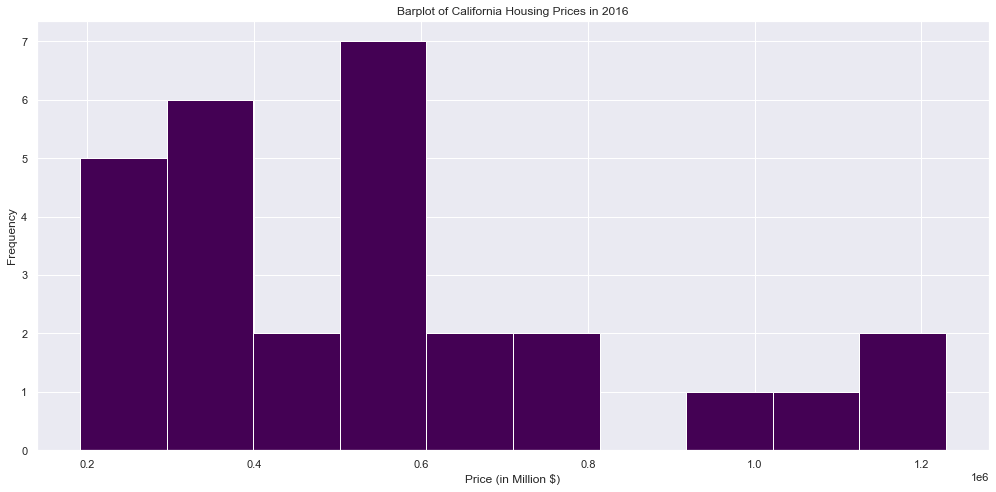

In [103]:
fig = df[df['year'] == 2016]['price'].plot.hist(colormap='viridis')
plt.title('Barplot of California Housing Prices in 2016')
plt.xlabel('Price (in Million $)')
plt.tight_layout()
plt.show()

Here we have a simple barplot of average county home prices binned into \\$100,000 price ranges. We see a clustering towards lower housing prices around two to four hundred thousand, with another peak at the \\$500,000 price range.

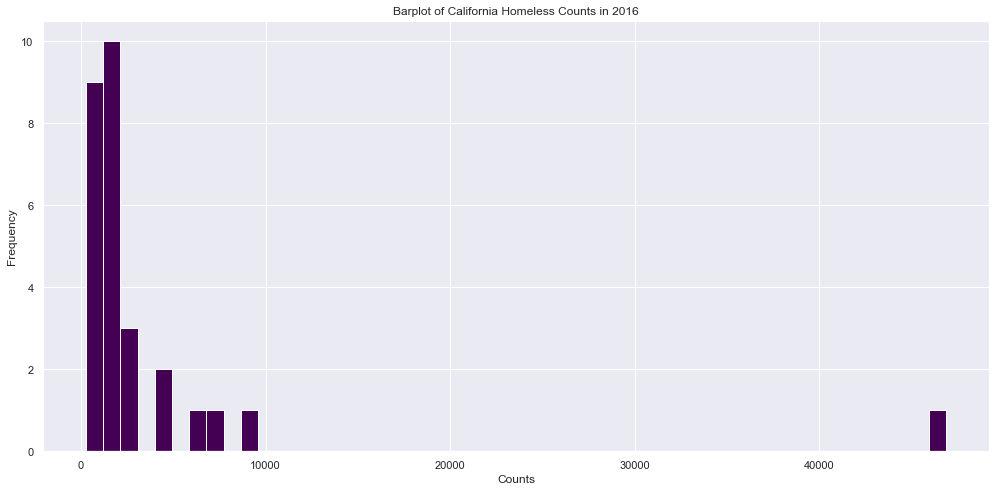

In [104]:
fig = df[df['year'] == 2016]['counts'].plot.hist(bins=50, colormap='viridis')
plt.title('Barplot of California Homeless Counts in 2016')
plt.xlabel('Counts')
plt.tight_layout()
plt.show()

Here we have a simple barplot of homeless counts in counties binned in intervals of about 1000. We see a large concentration in the lower range, with an extreme outlier (probably Los Angeles) in the higher range. This shows that it may be best to look at proportions of homeless vs. total county population as opposed to raw counts.

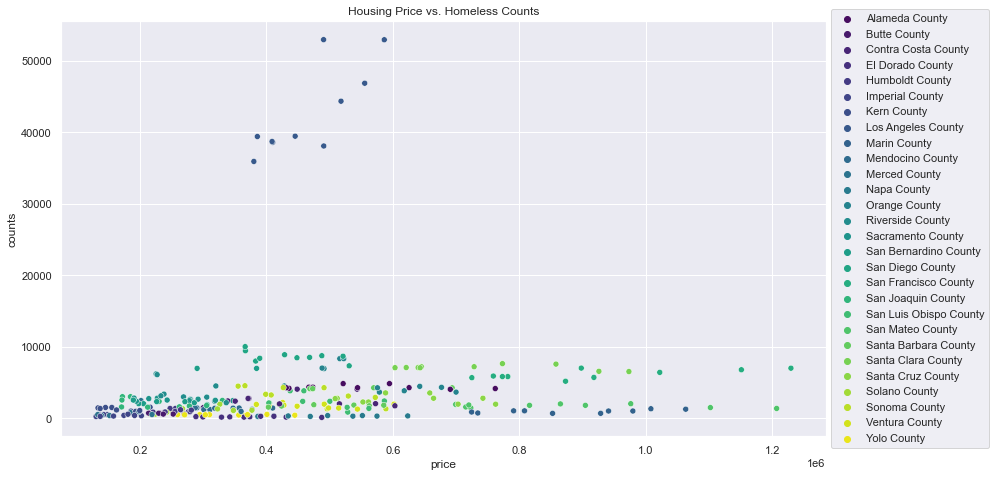

In [105]:
fig = sns.scatterplot(x='price', y='counts', data=df, hue='region', palette='viridis')
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.title('Housing Price vs. Homeless Counts')
plt.tight_layout()
plt.show()

Here is a scatterplot of Housing price vs. Homeless counts grouped into counties. We see that Los Angeles is a large outlier with an upward trend. In order to visualize the remaining counties better we will create the same plot and remove the outlier.

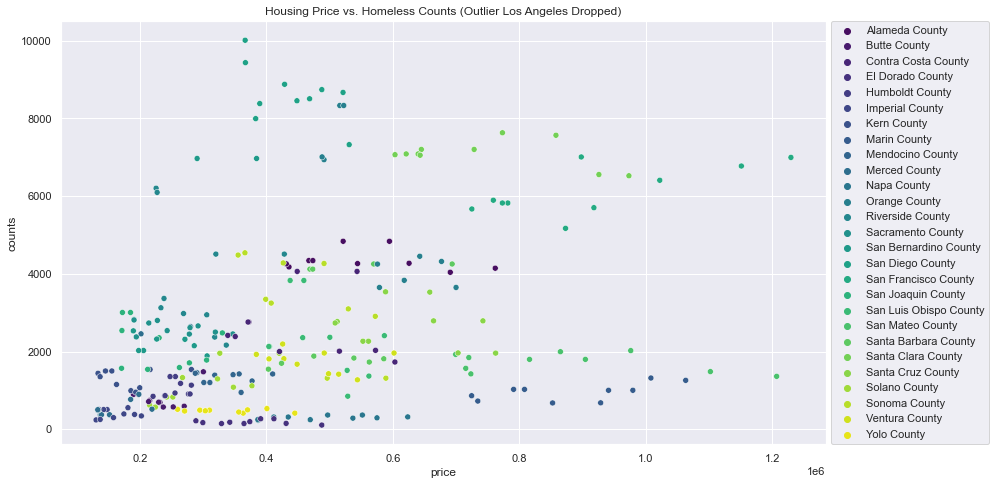

In [106]:
fig = sns.scatterplot(x='price', y='counts', data=df[~(df['region'] == 'Los Angeles County')], hue='region', palette='viridis')
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.title('Housing Price vs. Homeless Counts (Outlier Los Angeles Dropped)')
plt.tight_layout()
plt.show()

Here is the same scatter plot without Los Angeles. We can see much more information. For example we see some clusters of counties with upward trends, and also some clusters of counties with relatively flat trends. 

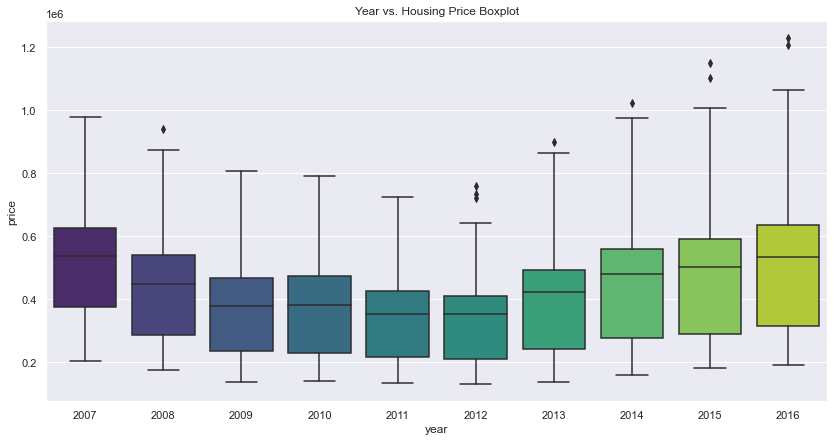

In [107]:
g1 = sns.boxplot(x='year', y='price', data=df, palette='viridis')
g1.set(title='Year vs. Housing Price Boxplot')
plt.show()

In [108]:
price_outliers = df[df['price'] > 1e6]

In [109]:
price_outliers

,year,state,region,price,counts,population
213,2014,CA,San Francisco County,1022088,6408,848448
232,2015,CA,Marin County,1008074,1318,262409
241,2015,CA,San Francisco County,1151177,6775,858224
244,2015,CA,San Mateo County,1102126,1483,760343
260,2016,CA,Marin County,1063108,1258,263210
269,2016,CA,San Francisco County,1229571,6996,865709
272,2016,CA,San Mateo County,1206972,1361,766589


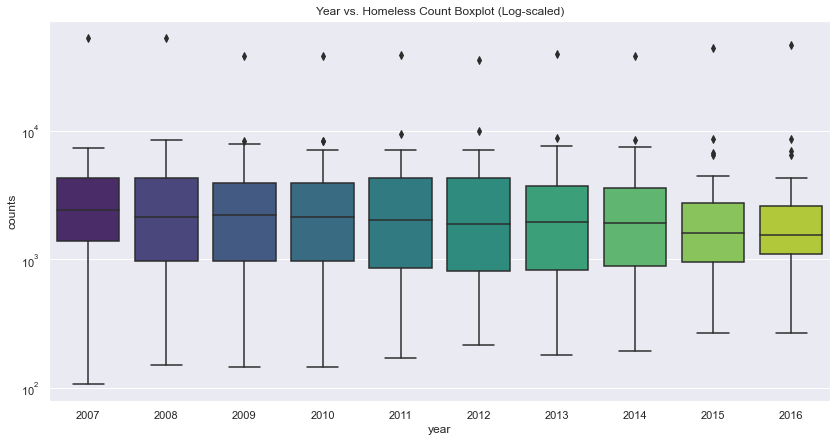

In [110]:
g1 = sns.boxplot(x='year', y='counts', data=df, palette='viridis')
g1.set(yscale='log')
g1.set(title='Year vs. Homeless Count Boxplot (Log-scaled)')
plt.show()

In [111]:
cnt_outliers = df[df['counts'] > 1e4]

In [112]:
cnt_outliers

,year,state,region,price,counts,population
7,2007,CA,Los Angeles County,586322,52956,9780808
35,2008,CA,Los Angeles County,490321,52970,9785474
63,2009,CA,Los Angeles County,409902,38602,9801096
91,2010,CA,Los Angeles County,408818,38717,9822121
119,2011,CA,Los Angeles County,385554,39414,9871802
147,2012,CA,Los Angeles County,380037,35926,9949794
156,2012,CA,San Diego County,366262,10013,3153521
175,2013,CA,Los Angeles County,445363,39461,10020599
203,2014,CA,Los Angeles County,490569,38089,10088458
231,2015,CA,Los Angeles County,517887,44359,10149661


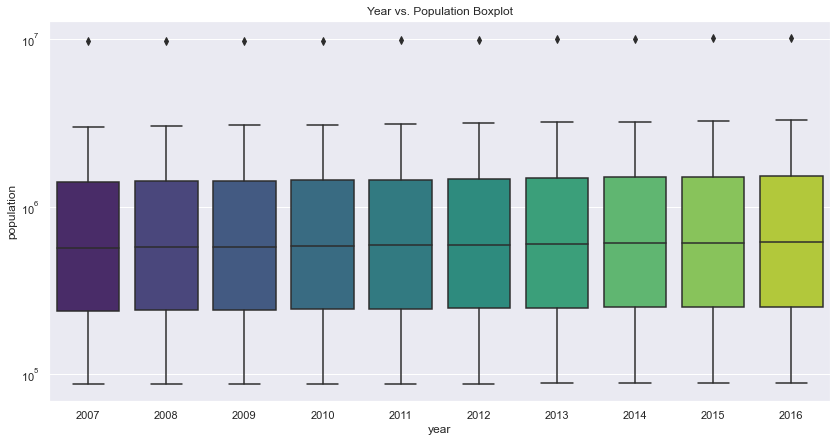

In [113]:
g1 = sns.boxplot(x='year', y='population', data=df, palette='viridis')
g1.set(yscale='log')
g1.set(title='Year vs. Population Boxplot')
plt.show()

In [114]:
pop_outliers = df[df['population'] > 8e6]

In [115]:
pop_outliers

,year,state,region,price,counts,population
7,2007,CA,Los Angeles County,586322,52956,9780808
35,2008,CA,Los Angeles County,490321,52970,9785474
63,2009,CA,Los Angeles County,409902,38602,9801096
91,2010,CA,Los Angeles County,408818,38717,9822121
119,2011,CA,Los Angeles County,385554,39414,9871802
147,2012,CA,Los Angeles County,380037,35926,9949794
175,2013,CA,Los Angeles County,445363,39461,10020599
203,2014,CA,Los Angeles County,490569,38089,10088458
231,2015,CA,Los Angeles County,517887,44359,10149661
259,2016,CA,Los Angeles County,555352,46874,10180169


## Data Analysis

We talked above about how it may be better to look at proportion o fhomeless population with respect to total populations so we will create this proportion as a new feature in our dataframe.

In [116]:
df['proportion'] = df['counts'] / df['population']

In [117]:
df.head()

,year,state,region,price,counts,population,proportion
0,2007,CA,Alameda County,594501,4838,1470622,0.003290
1,2007,CA,Butte County,300164,1478,216401,0.006830
2,2007,CA,Contra Costa County,543255,4062,1015672,0.003999
3,2007,CA,El Dorado County,487441,107,176226,0.000607
4,2007,CA,Humboldt County,276615,907,132443,0.006848


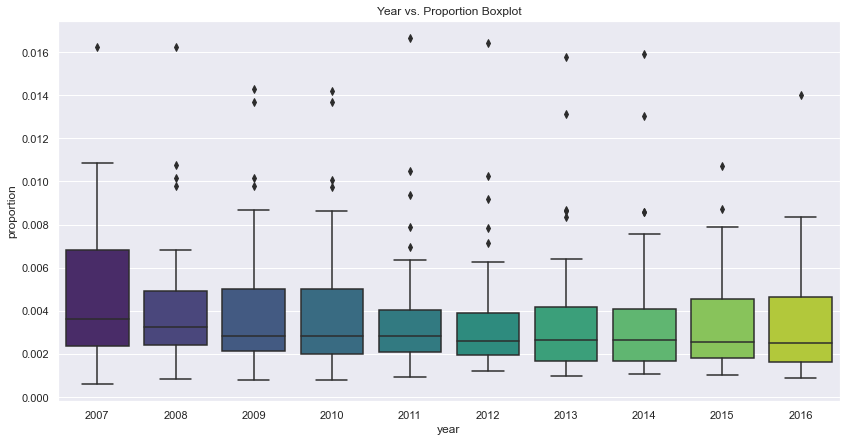

In [118]:
g1 = sns.boxplot(x='year', y='proportion', data=df, palette='viridis')
g1.set(title='Year vs. Proportion Boxplot')
plt.show()

Here we have the boxplot of the new proportion feature across the years in the dataset. We see a significantly different picture with more variance in the quartile regions and many more outliers. We list the outliers below. Note that LA is no longer considered an outlier when looking at proportions and instead we see more of Merced, Santa Cruz, Mendocino, etc.

In [119]:
prop_outliers = df[df['proportion'] > 0.009]

In [120]:
prop_outliers

,year,state,region,price,counts,population,proportion
9,2007,CA,Mendocino County,409739,1422,87617,0.016230
10,2007,CA,Merced County,279924,2641,247542,0.010669
19,2007,CA,San Luis Obispo County,586461,2408,262982,0.009157
21,2007,CA,Santa Barbara County,693703,4253,414750,0.010254
23,2007,CA,Santa Cruz County,742379,2789,256543,0.010871
37,2008,CA,Mendocino County,356770,1423,87715,0.016223
38,2008,CA,Merced County,201531,2455,250734,0.009791
49,2008,CA,Santa Barbara County,569592,4253,418309,0.010167
51,2008,CA,Santa Cruz County,664274,2789,258737,0.010779
60,2009,CA,Humboldt County,255871,1355,133484,0.010151


# Regression

We will run two different regression models, one comparing housing price with raw homeless populations, and another comparing housing price with homeless proportion of total poplation.

In [121]:
df.head()

,year,state,region,price,counts,population,proportion
0,2007,CA,Alameda County,594501,4838,1470622,0.003290
1,2007,CA,Butte County,300164,1478,216401,0.006830
2,2007,CA,Contra Costa County,543255,4062,1015672,0.003999
3,2007,CA,El Dorado County,487441,107,176226,0.000607
4,2007,CA,Humboldt County,276615,907,132443,0.006848


In [122]:
df_avg = df.groupby('region').mean().drop('year', axis=1)

In [123]:
# run model
outcome, predictors = patsy.dmatrices('counts ~ price', df_avg)
mod = sm.OLS(outcome, predictors)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                 counts   R-squared:                       0.017
Model:                            OLS   Adj. R-squared:                 -0.021
Method:                 Least Squares   F-statistic:                    0.4568
Date:                Tue, 08 Jun 2021   Prob (F-statistic):              0.505
Time:                        13:03:52   Log-Likelihood:                -290.20
No. Observations:                  28   AIC:                             584.4
Df Residuals:                      26   BIC:                             587.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1878.7710   3484.463      0.539      0.5

In [124]:
# run model
outcome, predictors = patsy.dmatrices('proportion ~ price', df_avg)
mod = sm.OLS(outcome, predictors)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:             proportion   R-squared:                       0.029
Model:                            OLS   Adj. R-squared:                 -0.009
Method:                 Least Squares   F-statistic:                    0.7705
Date:                Tue, 08 Jun 2021   Prob (F-statistic):              0.388
Time:                        13:03:52   Log-Likelihood:                 122.24
No. Observations:                  28   AIC:                            -240.5
Df Residuals:                      26   BIC:                            -237.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0030      0.001      2.161      0.0

In [125]:
# Dropping outliers
df_raw = df_avg[['price', 'counts']]
df_raw = df_raw[(np.abs(stats.zscore(df_raw)) < 3).all(axis=1)]

In [126]:
# Same OLS regression without outliers
outcome, predictors = patsy.dmatrices('counts ~ price', df_raw)
mod = sm.OLS(outcome, predictors)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                 counts   R-squared:                       0.162
Model:                            OLS   Adj. R-squared:                  0.129
Method:                 Least Squares   F-statistic:                     4.851
Date:                Tue, 08 Jun 2021   Prob (F-statistic):             0.0371
Time:                        13:03:52   Log-Likelihood:                -242.76
No. Observations:                  27   AIC:                             489.5
Df Residuals:                      25   BIC:                             492.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    816.3070    885.397      0.922      0.3

In [127]:
# Dropping outliers
df_prop = df_avg[['price', 'proportion']]
df_prop = df_prop[(np.abs(stats.zscore(df_prop)) < 3).all(axis=1)]

In [128]:
# Same OLS regression without outliers
outcome, predictors = patsy.dmatrices('proportion ~ price', df_prop)
mod = sm.OLS(outcome, predictors)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:             proportion   R-squared:                       0.099
Model:                            OLS   Adj. R-squared:                  0.063
Method:                 Least Squares   F-statistic:                     2.758
Date:                Tue, 08 Jun 2021   Prob (F-statistic):              0.109
Time:                        13:03:52   Log-Likelihood:                 126.36
No. Observations:                  27   AIC:                            -248.7
Df Residuals:                      25   BIC:                            -246.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0022      0.001      2.096      0.0

# Inferential Analysis

Below we use our data to do regression testing in order to visually be able to see if there is a trend. We use linear regression.

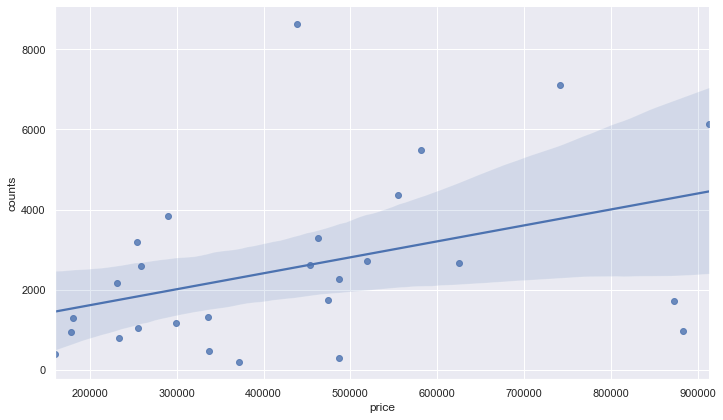

In [129]:
# First, we use housing price vs homeless count without normalizing for population.
sns.lmplot(x = 'price', y = 'counts', data = df_raw, fit_reg = True, height = 6, aspect = 1.7)
plt.tight_layout()
plt.show()

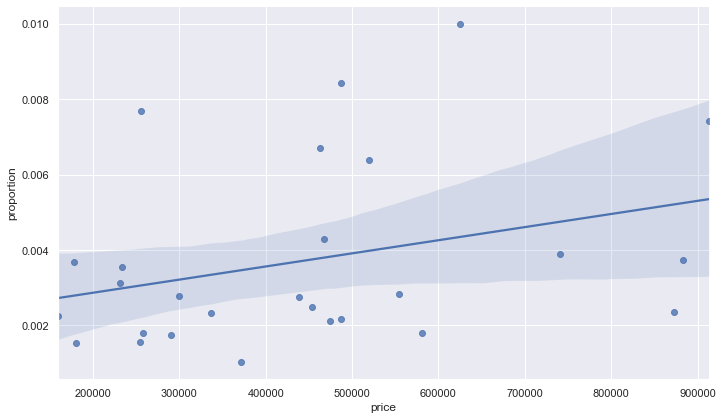

In [130]:
# Second, we use housing price vs population normalized homeless counts.
sns.lmplot(x = 'price', y = 'proportion', data = df_prop, fit_reg = True, height = 6, aspect = 1.7)
plt.tight_layout()
plt.show()

From the lmplot regression above we see a slight upward slope with a larger skew as we reach higher prices. This is due to possibly lower number of data points. Also we have some values with high proportions at lower price ranges as well. Since we already knew there was no significant correlation, this linear regression plots were just used for visual confirmation. 

# Ethics & Privacy

**Ethics:**

We must be aware of the limits of current datasets on homeless populations. Recent estimates put the count at around 540,000 but the Zillow study above menitoned that this may be an underestimation. We must cross reference statistical information within our chosen dataset with outside sources to verify its validity. An additional bias with regards to the homelessness data is that certain high density homeless areas may not be able to collect accurate counts, something also mentioned in the Zillow study. 

We will actively select broad-ranging datasets so as to not introduce inequity in terms of the populations studied. We will take general homeless populations and general housing prices and hope that if the data is sufficiently large that any outliers will get smoothed out in the distribution.

We will make sure to perform adequate exploratory analysis of our dataset in order to probe out any potential biases or lacking information about the general populations we wish to study.

**Privacy:**

We will make sure to only use data that does not include any personal information. This will be easier than ethical concerns as most homelessness dataset is by count and does not include personal information on individuals.

For the housing data we will also use average values within regions or years and therefore will not use personal data on individual houses or individual's income related to housing market costs in their area.

# Conclusion & Discussion

When we started this study, we hypothesized that there will be a correlation between housing prices in a neighborhood versus number of homeless people in that neighborhood. This study, however, showed that there is no significant correlation between the two, which means neighborhoods with high housing costs have similar homeless people counts as neightborhoods with low housing costs. 

We started the study by using three datasets, Zillow's housing index dataset, Kaggle's homeless counts dataset, and total California population dataset. After cleanup and merging of these datasets we were left with 28 California counties that contained homeless counts, average house prices, and total population. We used this data to first plot barplots of both housing price and homeless counts in the year 2016 (we chose this year as an example). Doing this helped us see any outliers in the dataset, and indeed, there were some outliers in homeless counts dataset in the year 2016. The housing dataset also showed some clustering between \\$400,000 to \\$700,000 range and \\$1.0 to \\$1.2million range. Upon a closer look, the outlier turned out to be Los Angeles, as it has historically had a large homeless population. However, we also know that Los Angeles is one of the densest and highest populated cities in the United States and so we decided to do homeless counts to total population proportion comparisons instead. 

Using scatterplot of housing price vs homeless counts, we see yet again that Los Angeles is such a big outlier that it doesn't let us see any trends in the other counties. So this time we remove Los Angeles from our scatterplot and we can see much better varience within other counties. For one, we see that most counties have below 10,000 homeless counts, and most counties have housing prices below \\$800,000. We also see that there is less data in general for higher housing prices. It is hard to tell any trends from these scatterplots so we may come back and use Ordinary Least Squares (OLS) analysis to see if there is any correlation. Meanwhile, we use boxplots of years vs homeless to total population proportion to see if we could gather any other details about trends and here we see that Los Angeles is not an outlier anymore and counties such as Santa Cruz, Merced, San Luis Obispo and Santa Barbara are among counties that contain proportionally high homeless counts. 

We come back to regression testing to see if what we saw visually, that is an absence of a trend, also holds statistically. First we use OLS to see the effect of average(across the years) housing price on homeless counts. Here we see that our P-value is 0.5, which implies that there is no statistically significant correlation between the two. Effect of price on homeless to population proportion also showed no statistically significant correlation with a P-value of 0.3. However, dropping the outliers in homeless counts dataset and re-running the same effect of housing price on homeless population counts gave us the smallest P-value of 0.037. Which by no means is a sign of significant correlation. Similarly, using the dataset with no outliers gave us a P-value of 0.109 for effect of housing price on homeless to population proportion. This concludes our study for any correlation between housing price and homeless counts within 28 counties in California. No significant correlation was found. 

This study could benefit from a better homeless counts dataset that contained not only more counties, but also more years. Homeless counts dataset was the limiting factor in this study. Other ways to add to this study would be to look at different categories for homelessness seperately, such as sheltered, unsheltered, families, etc... Perhaps this could reveal some trends. 

# Team Contributions

Allen Chung | background research, final presentation

Amita Haravu | background research, final presentation

Antoinette Nguyen | background research

Arman Mansourian | data cleaning, EDA

Areg Stepanyan | assisted with data cleaning and EDA, conclusion